In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import pandas as pd
from paho.mqtt import client as mqtt_client
from datetime import datetime
import random
%matplotlib inline

In [2]:
broker = 'broker.hivemq.com'
port = 1883
client_id = f'n1-sd-hidroponia-{random.randint(0, 1000)}'
topics = {
    'n1_sd_hidro_ph_get_result': 'Solicitado calculo resultado do PH',
    'n1_sd_hidro_ph_calculate_result': 'Calculado resultado do PH',
}

def on_connect(client, userdata, flags, rc):
    if rc == 0:
        print("Conectado ao MQTT Broker!")
    else:
        print("Falha ao se conectar, código %d\n", rc)

In [3]:
client = mqtt_client.Client(client_id)
client.on_connect = on_connect
client.connect(broker, port)
client.loop_start()

In [4]:
def publish(topic, msg):
    result = client.publish(topic, msg)
    status = result[0]
    if status == 0:
        print(f"Enviado `{msg}` para `{topics[topic]}`")
    else:
        print(f"Falha ao enviar mensagem para o tópico {topic}")
        
def subscribe(topic):
    def on_message(client, userdata, msg):
        now = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
        print(f"Recebido `{msg.payload.decode()}` para `{topics[msg.topic]}` em `{now}`")
        
        score = get_value(msg.payload.decode())
        publish('n1_sd_hidro_ph_calculate_result', score)

    client.subscribe(topic)
    client.on_message = on_message

In [5]:
subscribe('n1_sd_hidro_ph_get_result')

Conectado ao MQTT Broker!


       Temperature         PH
count    14.000000  14.000000
mean     18.285714  10.285714
std      10.542431   3.891382
min       5.000000   4.000000
25%      10.250000   7.250000
50%      16.000000  10.500000
75%      21.750000  13.750000
max      39.000000  16.000000
intercept [5.0019802]
coef [[0.30514851]]


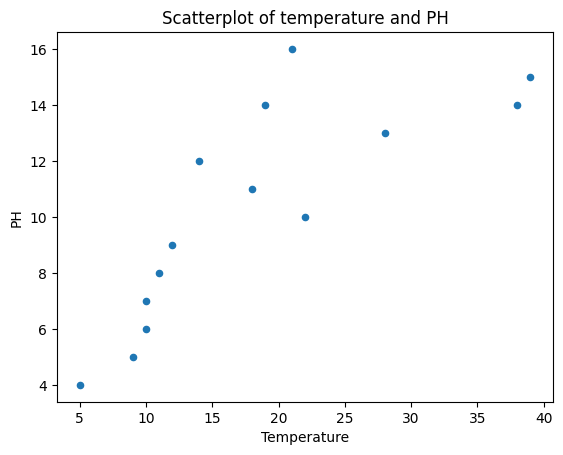

Recebido `25` para `Solicitado calculo resultado do PH` em `15/10/2022 14:32:00`
score [[12.63069307]]
Enviado `12.630693069306933` para `Calculado resultado do PH`


In [6]:
df = pd.read_csv('data.csv')
df.head()
df.shape
df.plot.scatter(x='Temperature', y='PH', title='Scatterplot of temperature and PH');
print(df.describe())

X = df['Temperature'].values.reshape(-1, 1)
Y = df['PH'].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

regressor = LinearRegression()
regressor.fit(X_train, y_train)
print('intercept', regressor.intercept_)
print('coef', regressor.coef_)
    
def get_value(temperature):
    numTemp = float(temperature)
    score = regressor.predict([[numTemp]])
    print('score', score)
    return score[0][0]

In [ ]:
client.loop_stop()